# What is Daft?

## Python Library

You can install Daft easily with `pip`:

In [ ]:
!pip install -U 'daft[iceberg,hudi,deltalake]'
!pip install -U ipywidgets

In [ ]:
CI = False

In [ ]:
# Skip this notebook execution in CI because it hits non-public data in AWS
if CI:
    import sys

    sys.exit()

## Cloud-Native Dataframe API

You can easily read from various sources of data (including cloud object storage and open table formats) into a Dataframe.

See ([Daft API Documentation: Input/Output](https://www.getdaft.io/projects/docs/en/latest/api_docs/input_output.html))

In [ ]:
import daft

ANONYMOUS_IO_CONFIG = daft.io.IOConfig(s3=daft.io.S3Config(anonymous=True, region_name="us-west-2"))

In [ ]:
### Iceberg

from pyiceberg.catalog.glue import GlueCatalog

catalog = GlueCatalog("default")
iceberg_table = catalog.load_table("tpch_iceberg_sf100.lineitem")

ice_df = daft.read_iceberg(iceberg_table)
ice_df.show()

In [ ]:
### Hudi

hudi_df = daft.read_hudi("s3://daft-public-data/hudi/v6_simplekeygen_nonhivestyle/", io_config=ANONYMOUS_IO_CONFIG)
hudi_df.show()

In [ ]:
### DeltaLake

delta_df = daft.read_deltalake(
    "s3://daft-public-data/nyc-taxi-dataset-2023-jan-deltalake/", io_config=ANONYMOUS_IO_CONFIG
)
delta_df.show()

In [ ]:
### Daft also supports reading from many other file sources:
# df = daft.read_csv(...)
# df = daft.read_parquet(...)
# df = daft.read_json(...)

### Read from SQL Databases
# df = daft.read_sql("SELECT * FROM table", "mysql://...")

### Glob a path into files
laion_df = daft.from_glob_path("s3://daft-public-data/laion-sample-images/*")

laion_df.show(3)

## Familiar, powerful relational operations + query optimizer

In [ ]:
# All the other dataframe operations that you would expect:
#
# 1. df.join(...)
# 2. df.sort(...)
# 3. df.with_column(...)
# 4. df.where(...)

import datetime

ice_df = daft.read_iceberg(iceberg_table)
ice_df = ice_df.where(ice_df["L_SHIPDATE"] < datetime.date(1993, 1, 1))
ice_df.explain(True)

In [ ]:
ice_df.show()

## Complex Data Types/Rust Core

Daft supports representing and performing operations on complex types such as URLs and images natively.

These operations are **defined** in Python, but **executed** using our Rust core library.

See ([Daft Documentation: Expressions](https://www.getdaft.io/projects/docs/en/latest/learn/user_guides/expressions.html))

In [ ]:
laion_df.show(3)

In [ ]:
laion_df = laion_df.with_column("data", laion_df["path"].url.download())  # Utf8 -> Binary
laion_df = laion_df.with_column("image", laion_df["data"].image.decode())  # Binary -> Image

In [ ]:
laion_df.show(3)

## Distributed Execution

Daft supports execution locally on a Python multithreaded backend, or on a Ray cluster.

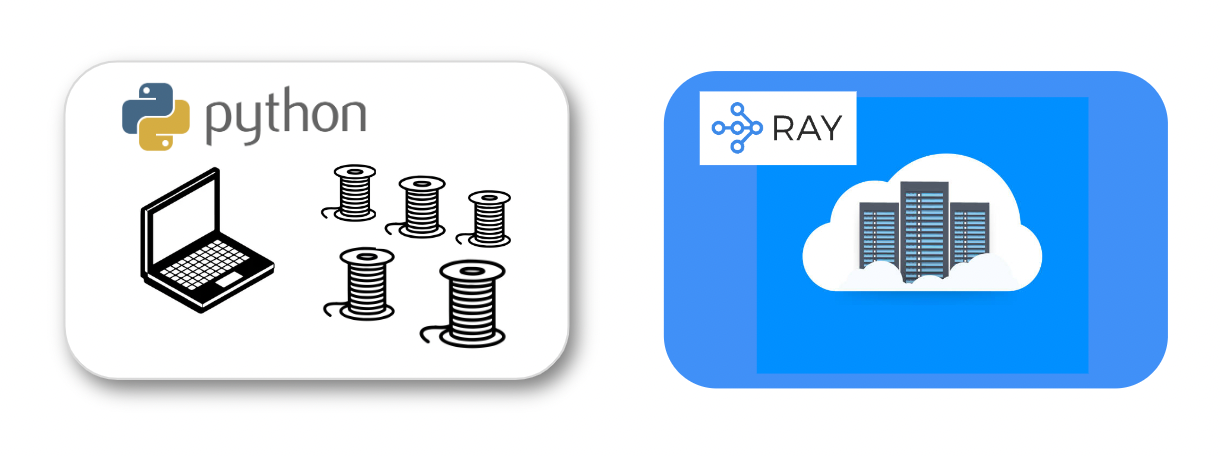

See ([Daft Documentation: Distributed Computing](https://www.getdaft.io/projects/docs/en/stable/learn/user_guides/poweruser/distributed-computing.html))

In [ ]:
## Use the Native multithreaded local runner (default behavior)
# daft.context.set_runner_native()

## Connect to a Ray cluster and use the Ray runner
# daft.context.set_runner_ray(address="ray://...")